<a href="https://colab.research.google.com/github/shoiTK/deep_learning_with_pytorch/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet codeing
【特徴】
通常のNNの出力：y = H(x)
resnetの出力　：y = F(x) + x
F(x)を学習することで、勾配損失を減らし、層を増やしても精度の低下を防ぐことができる。

In [1]:
import torch
import torch.nn as nn

--2020-11-27 08:00:54--  https://www.bigdata-navi.com/aidrops/wp-content/uploads/2020/03/3-300x266.png
Resolving www.bigdata-navi.com (www.bigdata-navi.com)... 13.113.151.220
Connecting to www.bigdata-navi.com (www.bigdata-navi.com)|13.113.151.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13249 (13K) [image/png]
Saving to: ‘3-300x266.png’

3-300x266.png       100%[===================>]  12.94K  --.-KB/s    in 0s      

2020-11-27 08:00:54 (215 MB/s) - ‘3-300x266.png’ saved [13249/13249]



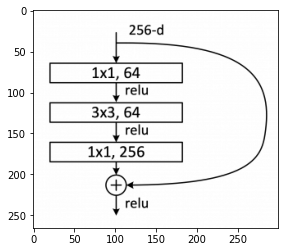

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

!wget https://www.bigdata-navi.com/aidrops/wp-content/uploads/2020/03/3-300x266.png
img = cv2.imread("/content/3-300x266.png")
plt.imshow(img)

In [55]:
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, channel_in, channel_out):
        super().__init__()
        channel = channel_out // 4

        # 1x1 の畳み込み
        self.conv1 = nn.Conv2d(channel_in, channel,
                               kernel_size=(1, 1))
        self.bn1 = nn.BatchNorm2d(channel)
        self.relu1 = nn.ReLU()

        # 3x3 の畳み込み
        self.conv2 = nn.Conv2d(channel, channel,
                               kernel_size=(3, 3),
                               padding=1)
        self.bn2 = nn.BatchNorm2d(channel)
        self.relu2 = nn.ReLU()

        # 1x1 の畳み込み
        self.conv3 = nn.Conv2d(channel, channel_out,
                               kernel_size=(1, 1),
                               padding=0)
        self.bn3 = nn.BatchNorm2d(channel_out)

        # skip connection用のチャネル数調整        
        self.shortcut = self._shortcut(channel_in, channel_out)
        
        self.relu3 = nn.ReLU()

    def forward(self, x):
        h = self.conv1(x)
        h = self.bn1(h)
        h = self.relu1(h)
        h = self.conv2(h)
        h = self.bn2(h)
        h = self.relu2(h)
        h = self.conv3(h)
        h = self.bn3(h)
        shortcut = self.shortcut(x)
        y = self.relu3(h + shortcut)  # skip connection
        return y

    def _shortcut(self, channel_in, channel_out):
        if channel_in != channel_out:
            return self._projection(channel_in, channel_out)
        else:
            return lambda x: x

    def _projection(self, channel_in, channel_out):
        return nn.Conv2d(channel_in, channel_out,
                         kernel_size=(1, 1),
                         padding=0)

In [45]:
import torch
import torch.nn as nn


class ResNet50(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 64,
                               kernel_size=(7, 7),
                               stride=(2, 2),
                               padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 3),
                                  stride=(2, 2),
                                  padding=1)

        # Block 1
        self.block0 = self._building_block(256, channel_in=64)
        self.block1 = nn.ModuleList([
            self._building_block(256) for _ in range(2)
        ])

        self.conv2 = nn.Conv2d(256, 512,
                               kernel_size=(1, 1),
                               stride=(2, 2))

        # Block 2
        self.block2 = nn.ModuleList([
            self._building_block(512) for _ in range(4)
        ])

        self.conv3 = nn.Conv2d(512, 1024,
                               kernel_size=(1, 1),
                               stride=(2, 2))

        # Block 3
        self.block3 = nn.ModuleList([
            self._building_block(1024) for _ in range(6)
        ])

        self.conv4 = nn.Conv2d(1024, 2048,
                               kernel_size=(1, 1),
                               stride=(2, 2))

        # Block 4
        self.block4 = nn.ModuleList([
            self._building_block(2048) for _ in range(3)
        ])

        self.avg_pool = GlobalAvgPool2d()  # TODO: GlobalAvgPool2d
        self.fc = nn.Linear(2048, 1000)
        self.out = nn.Linear(1000, output_dim)

    def forward(self, x):
        h = self.conv1(x)
        h = self.bn1(h)
        h = self.relu1(h)
        h = self.pool1(h)
        h = self.block0(h)
        for block in self.block1:
            h = block(h)
        h = self.conv2(h)
        for block in self.block2:
            h = block(h)
        h = self.conv3(h)
        for block in self.block3:
            h = block(h)
        h = self.conv4(h)
        for block in self.block4:
            h = block(h)
        h = self.avg_pool(h)
        h = self.fc(h)
        h = torch.relu(h)
        h = self.out(h)
        y = torch.log_softmax(h, dim=-1)

        return y

    def _building_block(self,
                        channel_out,
                        channel_in=None):
        if channel_in is None:
            channel_in = channel_out
        return Block(channel_in, channel_out)

In [40]:
import torch.nn.functional as F

class GlobalAvgPool2d(nn.Module):
  def __init__(self, device='cpu'):
    super().__init__()
  def forward(self, x):
    return F.avg_pool2d(x, kernel_size=x.size()[2:]).view(-1, x.size(1))

In [54]:
import numpy as np
import torch.optim as optimizers
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
import os


np.random.seed(1234)
torch.manual_seed(1234)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#data loader
root = os.path.join('content','..', 'data', 'fashion_mnist')
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = torchvision.datasets.FashionMNIST(root=root,
                                                download=True,
                                                train=True,
                                                transform=transform)
mnist_test = torchvision.datasets.FashionMNIST(root=root,
                                                download=True,
                                                train=False,
                                                transform=transform)
train_dataloader = DataLoader(mnist_train,
                              batch_size=100,
                              shuffle=True)
test_dataloader = DataLoader(mnist_test,
                              batch_size=100,
                              shuffle=False)
  
#model
model = ResNet50(10).to(device)

#model learn and eval
def compute_loss(label, pred):
  return criterion(pred, label)
  
def train_step(x, t):
  model.train()
  preds = model(x)
  loss = compute_loss(t, preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss, preds

def test_step(x, t):
  model.eval()
  preds = model(x)
  loss = compute_loss(t, preds)
  return loss, preds
  
criterion = nn.NLLLoss()
optimizer = optimizers.Adam(model.parameters(), weight_decay=0.01)
epochs = 5

for epoch in range(epochs):
  train_loss = 0.
  test_loss = 0.
  test_acc = 0.

  for (x, t) in train_dataloader:
    x, t = x.to(device), t.to(device)
    loss, _ = train_step(x, t)
    train_loss += loss.item()
    
  for (x, t) in test_dataloader:
    x, t = x.to(device), t.to(device)
    loss, preds = test_step(x, t)
    test_loss += loss.item()
    test_acc = accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())
  test_loss /= len(test_dataloader)
  test_acc /= len(test_dataloader)
  print('Epoch:{}, Valid Cost: {:.3f}, Valid Acc: {:.3f}'.format(epoch+1, test_loss, test_acc*100))

tensor([[[[ 4.4909e-02, -5.6257e-01, -4.7779e-01,  ..., -2.2711e-01,
           -1.1060e+00,  1.8678e-01],
          [ 1.6189e+00,  1.7891e+00, -3.5115e-01,  ...,  1.0442e+00,
           -1.3925e-01,  1.5568e+00],
          [ 1.8400e+00, -2.6928e-01,  1.2726e+00,  ...,  1.3109e+00,
            1.2686e-01,  2.6778e+00],
          ...,
          [ 7.9107e-01,  6.3343e-01, -1.4667e-01,  ..., -5.2461e-01,
            1.9576e-02, -8.3220e-04],
          [ 9.8009e-01, -1.4075e-02, -8.4098e-02,  ..., -6.2255e-01,
            8.4528e-01,  9.7076e-01],
          [ 4.5378e-01,  2.6888e-01, -1.1043e+00,  ...,  4.8731e-01,
           -4.6721e-01, -2.3872e-01]],

         [[ 1.0138e+00,  8.2702e-01, -3.6926e-03,  ..., -1.1213e-01,
            5.8648e-01, -1.3193e+00],
          [ 7.3954e-01,  1.0354e+00,  1.3257e+00,  ...,  1.5980e+00,
            1.4830e+00, -4.2736e-01],
          [ 1.8805e-01,  3.2866e-01, -9.2171e-01,  ..., -4.8589e-01,
           -5.6698e-01, -1.5920e+00],
          ...,
     

SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
